<a href="https://colab.research.google.com/github/chasubeen/ESAA_8th_OB/blob/Week_1/%ED%95%B8%EC%A6%88%EC%98%A8_3%EC%9E%A5_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3-1. MNIST**

In [1]:
### 데이터 불러오기

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
### 데이터 확인

X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

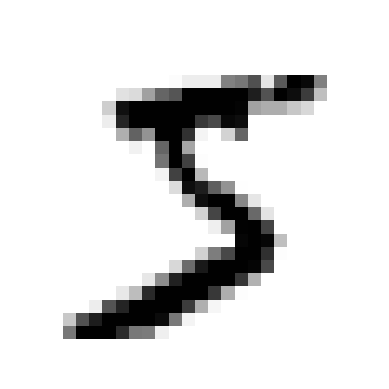

In [5]:
### 데이터 확인
# pixel -> image

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [6]:
# 실제 레이블 확인
y[0]

'5'

In [7]:
### 데이터형 변환
# 레이블(문자) -> 숫자(정수)

import numpy as np

y = y.astype(np.uint8)

In [8]:
### train_test_split

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# **3-2. 이진 분류기 훈련**

In [9]:
### target vector 생성

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
### 분류 모델 생성
# SGD 활용

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
### 숫자 '5' 이미지 감지

sgd_clf.predict([some_digit])

array([ True])

# **3-3. 성능 측정**

### **3-3-1. 교차 검증을 사용한 정확도 측정**

In [12]:
### 교차 검증 구현

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 모든 교차 검증 fold에 대해 정확도가 95% 이상

In [14]:
### 더미 분류기 생성 후 비교하기

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None): # 학습
    pass
  def predict(self, X): # 예측
    return np.zeros((len(X), 1), dtype = bool)

In [15]:
# 정확도 확인

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### **3-3-2. 오차 행렬**

In [16]:
### 타깃값 만들기

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3) # k-겹 교차 검증 수행 후 예측값 반환

In [17]:
### 오차 행렬 생성

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 진짜 음성(True Negative): 53057개
- 거짓 양성(False Positive): 687개
- 거짓 음성(False Negative): 1891개
- 진짜 양성(True Positive): 3530개

In [18]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기인 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### **3-3-3. 정밀도와 재현율**

In [19]:
### 정밀도

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
### 재현율

recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
### F1 Score

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### **3-3-4. 정밀도/재현율 트레이드오프**

In [22]:
### 각 샘플의 점수 확인

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- SGDClassifier의 임곗값이 0임
  - predict() 메서드와 같은 결과(= True)

In [24]:
# 임곗값을 더 높이면..

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
## 결정 점수 반환

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [26]:
### 정밀도-재현율 tradeoff

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [27]:
# 시각화

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

In [28]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

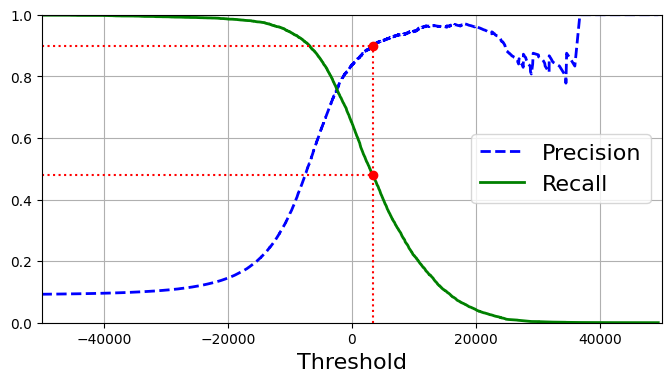

In [29]:
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

In [30]:
# 정밀도 90%를 달성하는 지점 찾기

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [31]:
# 훈련 세트에 대한 예측 만들기

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [32]:
## 정밀도-재현율 확인

precision_score(y_train_5, y_train_pred_90) # 정밀도

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90) # 재현율

0.4799852425751706

### **3-3-5. ROC 곡선**

In [34]:
### TPR, FPR 계산

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [35]:
# 시각화 함수

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

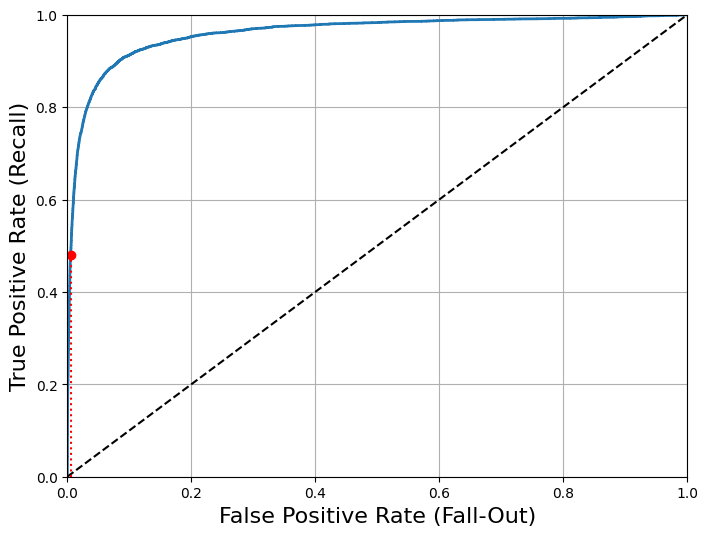

In [36]:
plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [37]:
### ROC-AUC 비교

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [38]:
### 다른 분류기와 비교
# 랜덤 포레스트 vs sgd
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                    cv=3, method="predict_proba")

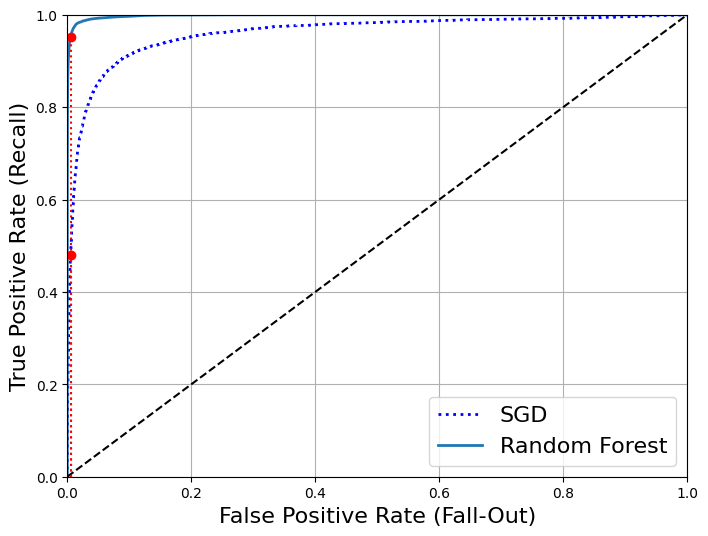

In [39]:
## roc-auc

y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# **3-4. 다중 분류**

In [41]:
### 서포트 벡터 머신에 적용
# SVC는 내부적으로 OvO 전략을 채택

from sklearn.svm import SVC

svm_clf = SVC(gamma = "auto", random_state = 42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
## 클래스 별 점수 확인

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [43]:
# 가장 높은 점수를 가지는 클래스 5를 최종 예측으로

np.argmax(some_digit_scores)

5

In [44]:
svm_clf.classes_ # 클래스 확인

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
svm_clf.classes_[5]

5

In [46]:
### SVC 기반으로 OvR 시도해보기

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma = "auto", random_state = 42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

In [48]:
### SGD 분류기
## 훈련 & 예측

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [49]:
## 클래스마다 부여한 점수 확인

sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- 분류기는 정답이 3이라고 강하게 확신하고 있음

In [50]:
## 분류기의 정확도 평가
# 교차 검증 활용

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

- 대부분 fold에서 85% 이상의 정확도를 얻음

In [51]:
## 성능 개선 시도
# 입력의 스케일 조정

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

- 정확도가 이전에 비해 조금 향상되었다.

# **3-5. 에러 분석**